In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
os.environ['CUDA_LAUNCH_BLOCKING']='1'
import torch
# GPU 사용 가능하면 cuda, 아니면 cpu
import torchvision
import torchvision.transforms as transforms
from torch import Tensor
from typing import List, Tuple, Dict, Any, Union


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.cuda.empty_cache()

In [2]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt


def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

In [3]:
transform = transforms.ToTensor()

batch_size = 256


trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

50000
torch.Size([3, 32, 32]) 6


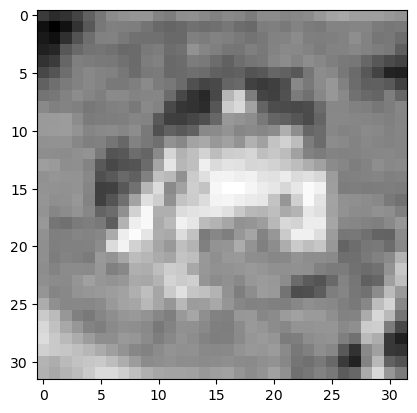

In [4]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

# NOTE

데이터 셋 구성

trainset[테스트 데이터 갯수][데이터와 정답, 튜플]
0 : 데이터 텐서
1 : 정답 값


In [5]:

print( type(trainset[0]))
print(len(trainset[0]))
print( type(trainset[0][0]))
print( type(trainset[0][1]))


<class 'tuple'>
2
<class 'torch.Tensor'>
<class 'int'>


In [6]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


In [7]:
from torch import nn


class ModelLeakyReLU(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model = ModelLeakyReLU(32 * 32 * 3, 1024)

이전 코드와 거의 똑같습니다. 다른 점은 `model.to(device)` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [8]:
# SGD
from torch.optim import SGD, Adam

lr = 0.001

model = ModelLeakyReLU(32 * 32 * 3, 1024)
model = model.to(device)

optimizer = SGD(model.parameters(), lr=lr)

n_epochs = 50
loss_fn = nn.CrossEntropyLoss()

train_sgd = []

for epoch in range(n_epochs):

  total_loss = 0.
  model.train()
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  with torch.no_grad():
    model.eval()  
    train_sgd.append(accuracy(model, trainloader))

  print(f"Epoch {epoch + 1:3d} | Loss: {total_loss}")

Epoch   1 | Loss: 450.4249405860901
Epoch   2 | Loss: 449.3063621520996
Epoch   3 | Loss: 448.3013608455658
Epoch   4 | Loss: 447.3678069114685
Epoch   5 | Loss: 446.46728467941284
Epoch   6 | Loss: 445.57595014572144
Epoch   7 | Loss: 444.65782833099365
Epoch   8 | Loss: 443.548725605011
Epoch   9 | Loss: 442.0822205543518
Epoch  10 | Loss: 440.57605147361755
Epoch  11 | Loss: 439.1242091655731
Epoch  12 | Loss: 437.6126925945282
Epoch  13 | Loss: 436.10576367378235
Epoch  14 | Loss: 434.60940504074097
Epoch  15 | Loss: 433.12213158607483
Epoch  16 | Loss: 431.6175391674042
Epoch  17 | Loss: 430.20564794540405
Epoch  18 | Loss: 428.777046918869
Epoch  19 | Loss: 427.4886305332184
Epoch  20 | Loss: 426.1746199131012
Epoch  21 | Loss: 424.98116183280945
Epoch  22 | Loss: 423.79905557632446
Epoch  23 | Loss: 422.68504571914673
Epoch  24 | Loss: 421.6321156024933
Epoch  25 | Loss: 420.614284992218
Epoch  26 | Loss: 419.6925721168518
Epoch  27 | Loss: 418.7558591365814
Epoch  28 | Loss: 41

## NOTE
model 은 클래스에서 인스턴스 뽑는거라 복제 됨

In [9]:
# Adam + LeakyReLU
model = ModelLeakyReLU(32 * 32 * 3, 1024)
model = model.to(device)

optimizer = Adam(model.parameters(), lr=lr)

train_adam = []
test_adam = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  with torch.no_grad():
    model.eval()
    train_adam.append(accuracy(model, trainloader))
    test_adam.append(accuracy(model, testloader))

  print(f"Epoch {epoch + 1:3d} | Loss: {total_loss}")

Epoch   1 | Loss: 415.6693003177643
Epoch   2 | Loss: 371.09285151958466
Epoch   3 | Loss: 348.8336296081543
Epoch   4 | Loss: 336.85473477840424
Epoch   5 | Loss: 324.1707618236542
Epoch   6 | Loss: 315.07275223731995
Epoch   7 | Loss: 307.75237596035004
Epoch   8 | Loss: 300.7871310710907
Epoch   9 | Loss: 295.0191992521286
Epoch  10 | Loss: 292.1619859933853
Epoch  11 | Loss: 284.8307116031647
Epoch  12 | Loss: 278.6325651407242
Epoch  13 | Loss: 274.2930089235306
Epoch  14 | Loss: 270.6302615404129
Epoch  15 | Loss: 264.93873608112335
Epoch  16 | Loss: 260.5960637331009
Epoch  17 | Loss: 257.85093557834625
Epoch  18 | Loss: 254.51910197734833
Epoch  19 | Loss: 247.88422334194183
Epoch  20 | Loss: 246.10748517513275
Epoch  21 | Loss: 240.7582732439041
Epoch  22 | Loss: 240.5383838415146
Epoch  23 | Loss: 236.04708230495453
Epoch  24 | Loss: 230.31506723165512
Epoch  25 | Loss: 229.11325979232788
Epoch  26 | Loss: 224.82827734947205
Epoch  27 | Loss: 220.9904459118843
Epoch  28 | Los

In [10]:
class ModelSigmoid(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.Sigmoid()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model = ModelSigmoid(32 * 32 * 3, 1024)

In [11]:
# Adam + Sigmoid


model = ModelSigmoid(32 * 32 * 3, 1024)
model = model.to(device)

optimizer = Adam(model.parameters(), lr=lr)

train_sigmoid = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  with torch.no_grad():
    model.eval()
    train_sigmoid.append(accuracy(model, trainloader))

  print(f"Epoch {epoch + 1:3d} | Loss: {total_loss}")

Epoch   1 | Loss: 411.71236312389374
Epoch   2 | Loss: 393.55797290802
Epoch   3 | Loss: 386.9949072599411
Epoch   4 | Loss: 384.0424197912216
Epoch   5 | Loss: 381.05338966846466
Epoch   6 | Loss: 379.4761588573456
Epoch   7 | Loss: 377.5810569524765
Epoch   8 | Loss: 376.103218793869
Epoch   9 | Loss: 374.02076160907745
Epoch  10 | Loss: 373.7193512916565
Epoch  11 | Loss: 372.06014490127563
Epoch  12 | Loss: 371.0751521587372
Epoch  13 | Loss: 369.9844696521759
Epoch  14 | Loss: 369.4358901977539
Epoch  15 | Loss: 368.8489656448364
Epoch  16 | Loss: 367.38879108428955
Epoch  17 | Loss: 366.5762234926224
Epoch  18 | Loss: 366.3661266565323
Epoch  19 | Loss: 365.56380093097687
Epoch  20 | Loss: 364.02939903736115
Epoch  21 | Loss: 364.41707372665405
Epoch  22 | Loss: 363.18487083911896
Epoch  23 | Loss: 362.69839572906494
Epoch  24 | Loss: 362.8451199531555
Epoch  25 | Loss: 361.63484942913055
Epoch  26 | Loss: 361.1821736097336
Epoch  27 | Loss: 361.6447001695633
Epoch  28 | Loss: 35

In [12]:
# Adam
model = ModelSigmoid(32 * 32 * 3, 1024)
model = model.to(device)

optimizer = Adam(model.parameters(), lr=lr)

train_adam = []
test_adam = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  with torch.no_grad():
    model.eval()
    train_adam.append(accuracy(model, trainloader))
    test_adam.append(accuracy(model, testloader))

  print(f"Epoch {epoch + 1:3d} | Loss: {total_loss}")

Epoch   1 | Loss: 409.46270966529846
Epoch   2 | Loss: 393.63019239902496
Epoch   3 | Loss: 387.1171554327011
Epoch   4 | Loss: 383.83059799671173
Epoch   5 | Loss: 381.46587455272675
Epoch   6 | Loss: 379.2100006341934
Epoch   7 | Loss: 377.0827649831772
Epoch   8 | Loss: 375.76769256591797
Epoch   9 | Loss: 374.4591281414032
Epoch  10 | Loss: 372.96231603622437
Epoch  11 | Loss: 371.55102920532227
Epoch  12 | Loss: 370.48122107982635
Epoch  13 | Loss: 369.875271320343
Epoch  14 | Loss: 369.1871279478073
Epoch  15 | Loss: 368.0332554578781
Epoch  16 | Loss: 367.8947502374649
Epoch  17 | Loss: 366.3475466966629
Epoch  18 | Loss: 365.60246109962463
Epoch  19 | Loss: 365.0958515405655
Epoch  20 | Loss: 364.3758444786072
Epoch  21 | Loss: 364.3989226818085
Epoch  22 | Loss: 363.2796891927719
Epoch  23 | Loss: 362.60181403160095
Epoch  24 | Loss: 362.1419087648392
Epoch  25 | Loss: 361.52355682849884
Epoch  26 | Loss: 361.5070685148239
Epoch  27 | Loss: 360.38194668293
Epoch  28 | Loss: 36

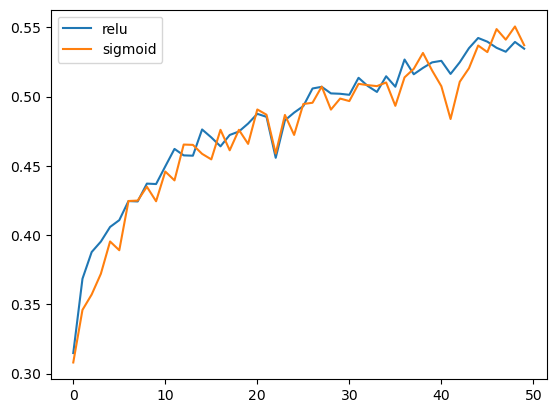

In [13]:
plot_acc(train_adam, train_sigmoid, 'relu', 'sigmoid')

# Dropout

In [14]:
# Dropout LeakyReLU

class Model3(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.dropout(self.act(self.layer1(x)))
    x = self.dropout(self.act(self.layer2(x)))
    x = self.dropout(self.act(self.layer3(x)))

    return x

In [15]:
model = Model3(32 * 32 * 3, 1024)
model = model.to(device)

optimizer = Adam(model.parameters(), lr=lr)

train_dropout = []
test_dropout = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train() # 추가됨
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  with torch.no_grad():
    model.eval()
    train_dropout.append(accuracy(model, trainloader))
    test_dropout.append(accuracy(model, testloader))

  print(f"Epoch {epoch + 1:3d} | Loss: {total_loss}")

Epoch   1 | Loss: 438.1286084651947
Epoch   2 | Loss: 417.3353958129883
Epoch   3 | Loss: 411.9347925186157
Epoch   4 | Loss: 402.05475652217865
Epoch   5 | Loss: 392.64576745033264
Epoch   6 | Loss: 385.5671052932739
Epoch   7 | Loss: 382.0958527326584
Epoch   8 | Loss: 376.32229220867157
Epoch   9 | Loss: 373.72312450408936
Epoch  10 | Loss: 368.71341264247894
Epoch  11 | Loss: 367.6802315711975
Epoch  12 | Loss: 363.123237490654
Epoch  13 | Loss: 362.3617705106735
Epoch  14 | Loss: 358.75173008441925
Epoch  15 | Loss: 356.18896102905273
Epoch  16 | Loss: 353.3992518186569
Epoch  17 | Loss: 351.1372700929642
Epoch  18 | Loss: 349.1782817840576
Epoch  19 | Loss: 349.024329662323
Epoch  20 | Loss: 348.1819534301758
Epoch  21 | Loss: 344.0572077035904
Epoch  22 | Loss: 341.4276577234268
Epoch  23 | Loss: 340.5313113927841
Epoch  24 | Loss: 338.2468774318695
Epoch  25 | Loss: 336.87398195266724
Epoch  26 | Loss: 335.38332653045654
Epoch  27 | Loss: 334.3174548149109
Epoch  28 | Loss: 333

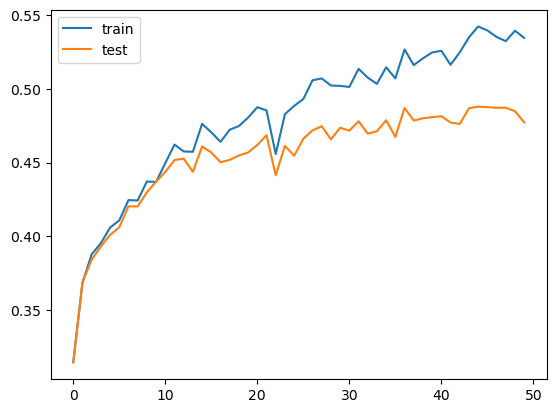

In [16]:
plot_acc(train_adam, test_adam)

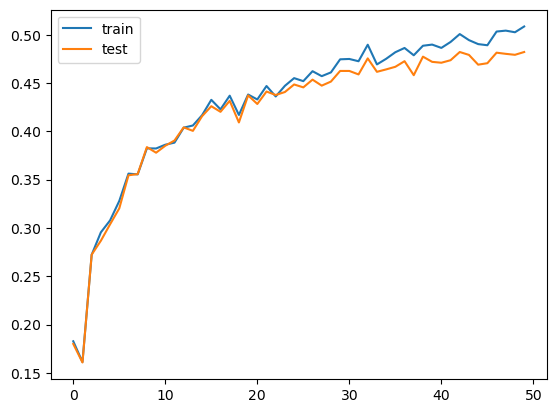

: 

In [17]:
plot_acc(train_dropout, test_dropout)